In [1]:
import pandas as pd

In [2]:
import pickle

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import Lasso

from sklearn.metrics import mean_squared_error

In [5]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    
    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)
    
    df = df[(df.duration >= 1) & (df.duration <= 60)]
    
    categorical = ["PULocationID", "DOLocationID"]
    df[categorical] = df[categorical].astype(str)
    
    return df

In [6]:
df_train = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-01.parquet")
df_val = read_dataframe("https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2024-02.parquet")

In [7]:
df_train

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-01-01 00:46:55,2024-01-01 00:58:25,N,1.0,236,239,1.0,1.98,12.80,...,0.5,3.61,0.0,NaN,1.0,21.66,1.0,1.0,2.75,11.500000
1,2,2024-01-01 00:31:42,2024-01-01 00:52:34,N,1.0,65,170,5.0,6.54,30.30,...,0.5,7.11,0.0,NaN,1.0,42.66,1.0,1.0,2.75,20.866667
2,2,2024-01-01 00:30:21,2024-01-01 00:49:23,N,1.0,74,262,1.0,3.08,19.80,...,0.5,3.00,0.0,NaN,1.0,28.05,1.0,1.0,2.75,19.033333
3,1,2024-01-01 00:30:20,2024-01-01 00:42:12,N,1.0,74,116,1.0,2.40,14.20,...,1.5,0.00,0.0,NaN,1.0,16.70,2.0,1.0,0.00,11.866667
4,2,2024-01-01 00:32:38,2024-01-01 00:43:37,N,1.0,74,243,1.0,5.14,22.60,...,0.5,6.28,0.0,NaN,1.0,31.38,1.0,1.0,0.00,10.983333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56546,2,2024-01-31 20:46:00,2024-01-31 20:55:00,None,NaN,33,25,NaN,0.00,11.58,...,0.0,3.14,0.0,NaN,1.0,15.72,NaN,NaN,NaN,9.000000
56547,2,2024-01-31 21:06:00,2024-01-31 21:11:00,None,NaN,72,72,NaN,0.49,11.58,...,0.0,0.00,0.0,NaN,1.0,12.58,NaN,NaN,NaN,5.000000
56548,2,2024-01-31 21:36:00,2024-01-31 21:40:00,None,NaN,72,72,NaN,0.52,11.58,...,0.0,2.52,0.0,NaN,1.0,15.10,NaN,NaN,NaN,4.000000
56549,2,2024-01-31 22:45:00,2024-01-31 22:51:00,None,NaN,41,42,NaN,1.17,14.22,...,0.0,0.00,0.0,NaN,1.0,15.22,NaN,NaN,NaN,6.000000


In [8]:
df_val

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2024-02-01 00:15:53,2024-02-01 00:24:20,N,1.0,75,161,1.0,2.77,13.50,...,0.5,3.75,0.0,NaN,1.0,22.50,1.0,1.0,2.75,8.450000
1,2,2024-01-31 22:59:22,2024-01-31 23:27:14,N,1.0,43,242,1.0,7.76,36.60,...,0.5,0.00,0.0,NaN,1.0,39.10,2.0,1.0,0.00,27.866667
2,2,2024-02-01 00:30:29,2024-02-01 00:35:32,N,1.0,75,238,1.0,1.03,7.90,...,0.5,2.60,0.0,NaN,1.0,13.00,1.0,1.0,0.00,5.050000
3,2,2024-01-31 23:56:42,2024-02-01 00:06:53,N,1.0,80,17,2.0,1.36,11.40,...,0.5,4.17,0.0,NaN,1.0,18.07,1.0,1.0,0.00,10.183333
5,2,2024-02-01 00:06:23,2024-02-01 00:10:10,N,1.0,97,25,1.0,0.34,5.10,...,0.5,0.00,0.0,NaN,1.0,7.60,2.0,1.0,0.00,3.783333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53572,2,2024-02-29 21:07:00,2024-02-29 21:34:00,None,NaN,223,137,NaN,5.43,32.16,...,0.0,7.18,0.0,NaN,1.0,43.09,NaN,NaN,NaN,27.000000
53573,2,2024-02-29 22:35:38,2024-02-29 22:46:25,None,NaN,256,37,NaN,1.50,2.70,...,0.0,2.74,0.0,NaN,1.0,6.44,NaN,NaN,NaN,10.783333
53574,2,2024-02-29 22:14:00,2024-02-29 22:39:00,None,NaN,75,33,NaN,10.07,47.14,...,0.0,15.27,0.0,NaN,1.0,66.16,NaN,NaN,NaN,25.000000
53575,2,2024-02-29 22:41:00,2024-02-29 22:53:00,None,NaN,97,33,NaN,1.54,12.22,...,0.0,3.30,0.0,NaN,1.0,16.52,NaN,NaN,NaN,12.000000


In [9]:
#Feature Engineering
df_train["PU_DO"] = df_train["PULocationID"] + "_" + df_train["DOLocationID"]
df_val["PU_DO"] = df_val["PULocationID"] + "_" + df_val["DOLocationID"]

In [10]:
dv = DictVectorizer()

categorical = ["PU_DO"] #["PULocationID", "DOLocationID"]
numerical = ["trip_distance"]

train_dicts = df_train[categorical + numerical].to_dict(orient="records")
X_train = dv.fit_transform(train_dicts)


val_dicts = df_val[categorical + numerical].to_dict(orient="records")
X_val = dv.transform(val_dicts)

In [11]:
target = "duration"
y_train = df_train[target].values
y_val = df_val[target].values

In [12]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
mean_squared_error(y_val, y_pred, squared=False)

5.995536436960285

- Lasso(alpha=0.001): 6.583
- Ridge(alpha=0.001): 5.996

In [13]:
# ls = Lasso(alpha=0.001)
# ls.fit(X_train, y_train)

# y_pred = ls.predict(X_val)
# mean_squared_error(y_val, y_pred, squared=False)

In [14]:
# ri = Ridge(alpha=0.001)
# ri.fit(X_train, y_train)

# y_pred = ri.predict(X_val)
# mean_squared_error(y_val, y_pred, squared=False)

/tmp/ipykernel_2544/1219225857.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label="prediction")
/home/codespace/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_2544/1219225857.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level fun

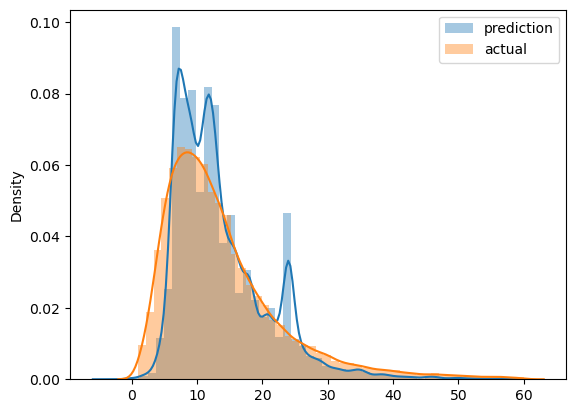

In [15]:
sns.distplot(y_pred, label="prediction")
sns.distplot(y_train, label="actual")

plt.legend()

In [16]:
# with open("../models/lr_model.bin", "wb") as f_out:
#     pickle.dump((dv, lr), f_out)